# Estudo e Caracterização de Filtro RC Passa-Banda

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.optimize import curve_fit

In [135]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 120
sns.set_theme()

## Funções e Constantes

In [136]:
def gain(w, w1, w2): return 1 / (np.sqrt(1 + (w1/w)**2) * np.sqrt(1 + (w/w2)**2))

In [151]:
def phase(w, w0): return np.degrees(np.arctan(w/w0))

In [137]:
R1, sR1 = 1000, 100
R2, sR2 = 4.67E3, 0.234E3
C1, sC1 = 0.47E-6, 0.047E-6
C2, sC2 = 10E-9, 1E-9
C3, sC3 = 1E-9, 0.1E-9

In [138]:
w1 = 1 / (2 * np.pi * R1 * C1)
w2 = 1 / (2 * np.pi * R2 * C2)
w3 = 1 / (2 * np.pi * R2 * C3)

In [139]:
w1, w2, w3

(338.62753849339435, 3408.0287599977587, 34080.287599977586)

## Filtro de 10 nF

In [140]:
df = pd.read_csv('dados/filtro_10nF.csv')

### Curva de Ganho

In [141]:
df['Inc. Ganho'] = np.sqrt( (df['Inc. Tensão Saída (V)']/df['Tensão Entrada (V)'])**2 + (df['Inc. Tensão Entrada (V)']*df['Tensão Saída (V)']/df['Tensão Entrada (V)']**2)**2 )

In [142]:
popt, pcov = curve_fit(
	gain,
	xdata=df['Frequência (Hz)'],
	ydata=df['Ganho'],
	sigma=df['Inc. Ganho'],
	p0=( w1, w2 )
)

In [143]:
popt

array([ 335.15466779, 3352.6315732 ])

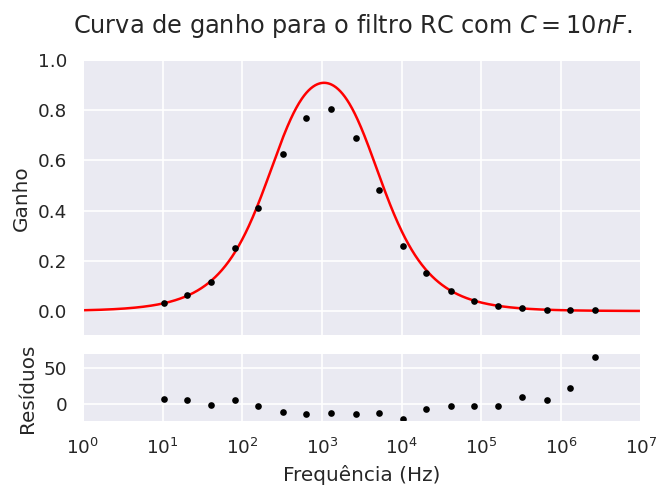

In [144]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.1, 'height_ratios': (4,1) })
plt.suptitle('Curva de ganho para o filtro RC com $C=10nF$.')

axs[0].errorbar(
	x=df['Frequência (Hz)'],
	y=df['Ganho'],
	xerr=df['Inc. Frequência (Hz)'],
	yerr=df['Inc. Ganho'],
	fmt=' ', marker='.', color='black'
)

x = np.logspace(0, 7, 1000)
sns.lineplot(x=x, y=gain(x, popt[0], popt[1]), color='red', ax=axs[0])
# sns.lineplot(x=x, y=gain(x, w2, w1), color='gray', ax=axs[0])

axs[1].errorbar(
	x=df['Frequência (Hz)'],
	y=(df['Ganho'] - gain(df['Frequência (Hz)'], popt[0], popt[1])) / df['Inc. Ganho'],
	xerr=df['Inc. Frequência (Hz)'],
	yerr=1,
	fmt=' ', marker='.', color='black'
)

axs[0].set(ylabel='Ganho', ylim=(-0.1, 1))
axs[1].set(xlabel='Frequência (Hz)', ylabel='Resíduos', xscale='log', xlim=(1E0, 1E7))
plt.show()

### Defasagem

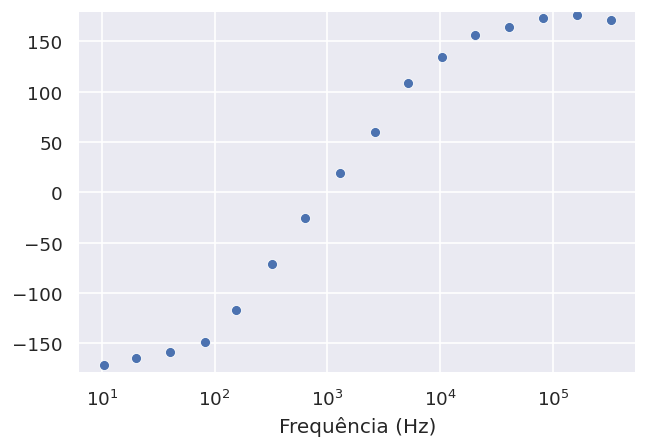

In [150]:
sns.scatterplot(x=df['Frequência (Hz)'], y=df['Fase Entrada (º)'] - df['Fase Saída (º)'])
plt.xscale('log')
plt.ylim(-180, 180)
plt.show()

## Filtro de 1 nF

In [129]:
df = pd.read_csv('dados/filtro_1nF.csv')

In [130]:
df['Inc. Ganho'] = np.sqrt( (df['Inc. Tensão Saída (V)']/df['Tensão Entrada (V)'])**2 + (df['Inc. Tensão Entrada (V)']*df['Tensão Saída (V)']/df['Tensão Entrada (V)']**2)**2 )

In [131]:
popt, pcov = curve_fit(
	gain,
	xdata=df['Frequência (Hz)'],
	ydata=df['Ganho'],
	sigma=df['Inc. Ganho'],
	p0=( w1, w3 )
)

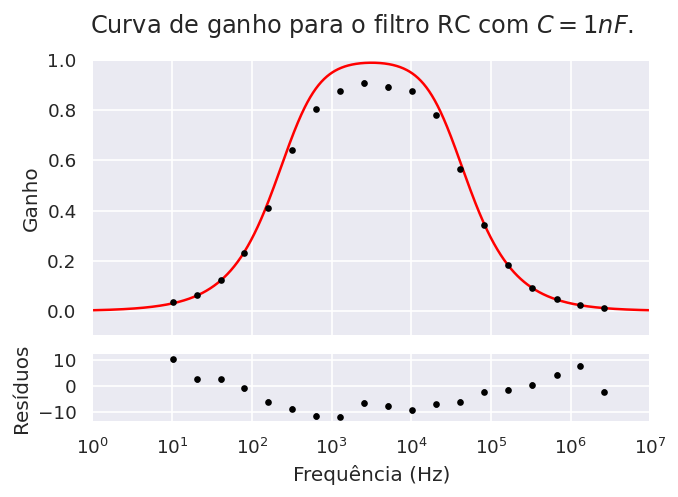

In [132]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={ 'hspace': 0.1, 'height_ratios': (4,1) })
plt.suptitle('Curva de ganho para o filtro RC com $C=1nF$.')

axs[0].errorbar(
	x=df['Frequência (Hz)'],
	y=df['Ganho'],
	xerr=df['Inc. Frequência (Hz)'],
	yerr=df['Inc. Ganho'],
	fmt=' ', marker='.', color='black'
)

x = np.logspace(0, 7, 1000)
sns.lineplot(x=x, y=gain(x, popt[0], popt[1]), color='red', ax=axs[0])

axs[1].errorbar(
	x=df['Frequência (Hz)'],
	y=(df['Ganho'] - gain(df['Frequência (Hz)'], popt[0], popt[1])) / df['Inc. Ganho'],
	xerr=df['Inc. Frequência (Hz)'],
	yerr=1,
	fmt=' ', marker='.', color='black'
)

axs[0].set(ylabel='Ganho', ylim=(-0.1, 1))
axs[1].set(xlabel='Frequência (Hz)', ylabel='Resíduos', xscale='log', xlim=(1E0, 1E7))
plt.show()